### Transfer Learning EfficientNet avec augmentation et recadrage 256x256

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.applications.efficientnet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB1
from sklearn import metrics
import tensorflow as tf


#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [2]:
data = pd.read_csv('../base_10_class.csv',index_col=0)

In [3]:
data_detour = pd.read_csv('../files_detour_256.csv',index_col=0)

In [4]:
# Garde seulement les images où le détourage possible pour comparaison avec/sans détourage
data = data[data['filename'].isin(data_detour['filename'])]

In [5]:
lst_classes = {'basophil':0,'blast':1,'eosinophil':2,
               'erythroblast':3,'ig':4,'lymphocyte':5,'monocyte':6,'neutrophil':7,'platelet':8,'smudge':9}

In [6]:
data['label'] = data['class'].apply(lambda cat: lst_classes[cat])

In [7]:
data.head()

,file_path,filename,class,label
0,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_100102.jpg,basophil,0
1,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_101381.jpg,basophil,0
2,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_101611.jpg,basophil,0
3,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_102039.jpg,basophil,0
4,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_102750.jpg,basophil,0


In [8]:
data_train, data_eval = train_test_split(data,test_size=0.1,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.1,random_state=123)

#### Utilisation d'un ImageDataGenerator

In [9]:
# Recadrage de l'image
def preprocess(img):
    img = tf.image.resize_with_crop_or_pad(img, 256, 256)
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)  # Preprocess de EfficientNet
    return img

In [16]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess,horizontal_flip=True, vertical_flip=True,
                                    rotation_range=180
                                                       )
test_generator = ImageDataGenerator(preprocessing_function=preprocess)

In [17]:
data_train_generator = data_generator.flow_from_dataframe(data_train, directory=None, x_col='file_path',y_col='class',class_mode ='sparse',target_size=(256,256),
                                              batch_size=32)

data_test_generator = data_generator.flow_from_dataframe(data_test, directory=None, x_col='file_path',y_col='class',class_mode ='sparse',target_size=(256,256),
                                              batch_size=32)

Found 25596 validated image filenames belonging to 10 classes.
Found 2845 validated image filenames belonging to 10 classes.


#### Transfer Learning avec modèle MobileNet
* Freeze de toutes les couches
* Couches Dense 1024, 512, 256 
* Dropout pour éviter overfitting
* Compilation avec Adam avec learning_rate de 10-4

In [18]:
# Création Callback pour stopper si stagnation
callback = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)

In [19]:
# Création d'un modèle MobileNet
def model_efficientNet():
    base_model = EfficientNetB1(
        weights='imagenet',  
        input_shape=(256, 256, 3),
        include_top=False)  
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(units=1024,activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=512,activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=256,activation='relu')(x)
    x = Dropout(0.2)(x)
    # A Dense classifier 
    outputs = Dense(units=10,activation='softmax')(x)
    model = Model(base_model.input, outputs)


    model.compile(optimizer='adam' ,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [20]:
model = model_efficientNet()

In [21]:
#Entrainement
history = model.fit(data_train_generator, epochs = 16, validation_data = data_test_generator,callbacks=[callback])

Epoch 1/16
800/800 [==============================] - 2861s 4s/step - loss: 0.9007 - accuracy: 0.6949 - val_loss: 0.5792 - val_accuracy: 0.8116
Epoch 2/16
800/800 [==============================] - 3026s 4s/step - loss: 0.6461 - accuracy: 0.7871 - val_loss: 0.4932 - val_accuracy: 0.8404
Epoch 3/16
800/800 [==============================] - 2986s 4s/step - loss: 0.5785 - accuracy: 0.8124 - val_loss: 0.4582 - val_accuracy: 0.8591
Epoch 4/16
800/800 [==============================] - 3167s 4s/step - loss: 0.5491 - accuracy: 0.8265 - val_loss: 0.4392 - val_accuracy: 0.8626
Epoch 5/16
800/800 [==============================] - 3059s 4s/step - loss: 0.5295 - accuracy: 0.8298 - val_loss: 0.4613 - val_accuracy: 0.8569
Epoch 6/16
800/800 [==============================] - 2980s 4s/step - loss: 0.5165 - accuracy: 0.8341 - val_loss: 0.4226 - val_accuracy: 0.8643
Epoch 7/16
800/800 [==============================] - 2985s 4s/step - loss: 0.4997 - accuracy: 0.8406 - val_loss: 0.4082 - val_accuracy:

In [22]:
model.save_weights("efficientnet_10_weights_augm")

#### Prédiction sur les données d'évaluation

In [ ]:
# model = model_mobileNet()
# model.load_weights("mobilenet_10_weights")

In [23]:
data_eval_generator = test_generator.flow_from_dataframe(data_eval, directory=None, x_col='file_path',y_col='class',class_mode ='sparse',target_size=(256,256),
                                              batch_size=32,shuffle=False)

Found 3161 validated image filenames belonging to 10 classes.


In [24]:
model.evaluate(data_eval_generator)

99/99 [==============================] - 346s 3s/step - loss: 0.4239 - accuracy: 0.8618


[0.423862099647522, 0.8617526292800903]

 * Score 86% avec augmentation de données, plus faible de 3% que sans =>?

#### Fine Tunning

In [26]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 256, 256, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization_1[0][0]            
_______________________________________________________________________________________

In [27]:
# Unfreeze dernier block Efficient 7b
for layer in model.layers[-26:]:
    layer.trainable = True

In [28]:
model.compile(optimizer=Adam(learning_rate=1e-4) ,loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3)

In [33]:
history = model.fit(data_train_generator, epochs = 16, validation_data = data_test_generator,callbacks=[reduce_lr,early_stopping])

Epoch 1/16
800/800 [==============================] - 3323s 4s/step - loss: 0.5173 - accuracy: 0.8397 - val_loss: 0.3393 - val_accuracy: 0.8886
Epoch 2/16
800/800 [==============================] - 3311s 4s/step - loss: 0.3966 - accuracy: 0.8713 - val_loss: 0.3380 - val_accuracy: 0.8921
Epoch 3/16
800/800 [==============================] - 3305s 4s/step - loss: 0.3624 - accuracy: 0.8837 - val_loss: 0.3143 - val_accuracy: 0.8967
Epoch 4/16
800/800 [==============================] - 3302s 4s/step - loss: 0.3364 - accuracy: 0.8921 - val_loss: 0.3130 - val_accuracy: 0.8974
Epoch 5/16
800/800 [==============================] - 3292s 4s/step - loss: 0.3238 - accuracy: 0.8938 - val_loss: 0.2699 - val_accuracy: 0.9086
Epoch 6/16
800/800 [==============================] - 3285s 4s/step - loss: 0.3117 - accuracy: 0.8976 - val_loss: 0.2934 - val_accuracy: 0.9030
Epoch 7/16
800/800 [==============================] - 3305s 4s/step - loss: 0.2940 - accuracy: 0.9035 - val_loss: 0.2841 - val_accuracy:

In [34]:
model.save_weights("efficientnet_10_weights_augm")

#### Evaluation des résultats

In [35]:
model.evaluate(data_eval_generator)

99/99 [==============================] - 302s 3s/step - loss: 0.2955 - accuracy: 0.9083


[0.29545682668685913, 0.9082568883895874]

In [36]:
#Classes prédites
predict = model.predict(data_eval_generator)

In [38]:
eval_predict_class = predict.argmax(axis = 1)
lst_classes = [key for key, val in data_eval_generator.class_indices.items()]
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in data_eval_generator.classes]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.94      0.95      0.95       118
       blast       0.82      0.89      0.86       325
  eosinophil       0.99      0.97      0.98       320
erythroblast       0.96      0.91      0.94       217
          ig       0.87      0.79      0.83       386
  lymphocyte       0.94      0.91      0.92       467
    monocyte       0.83      0.87      0.85       264
  neutrophil       0.96      0.96      0.96       580
    platelet       0.98      1.00      0.99       231
      smudge       0.79      0.84      0.81       253

    accuracy                           0.91      3161
   macro avg       0.91      0.91      0.91      3161
weighted avg       0.91      0.91      0.91      3161



> +1% avec augmentation de données seulement
>
> amélioration sur toutes les classes et 5% sur les IG

In [39]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,blast,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet,smudge
Réalité,,,,,,,,,,
basophil,112,0,0,1,2,0,1,0,1,1
blast,0,290,0,0,8,3,14,0,0,10
eosinophil,1,0,309,0,0,1,1,4,0,4
erythroblast,0,0,0,198,4,7,1,3,3,1
ig,6,33,0,1,306,3,17,8,0,12
lymphocyte,0,9,0,5,6,425,6,2,0,14
monocyte,0,7,0,0,10,1,230,4,0,12
neutrophil,0,2,3,0,6,3,4,559,0,3
platelet,0,0,0,1,0,0,0,0,230,0


> Confusion importante blaste/IG ainsi que monocyte/IG

In [40]:
# Récupère les cellules bien prédites => regarde la proba sur cette classe
compare = pd.DataFrame({'Réalité':data_eval['label'],'Prédiction':eval_predict_class}).reset_index()
predict_correct = compare[compare['Réalité']==compare['Prédiction']]

In [41]:
predict_by_class = []
for i in range(10):
    indexes = predict_correct[predict_correct['Réalité']==i].index
    pourcent = predict[indexes][:,i]
    predict_by_class.append(pourcent)

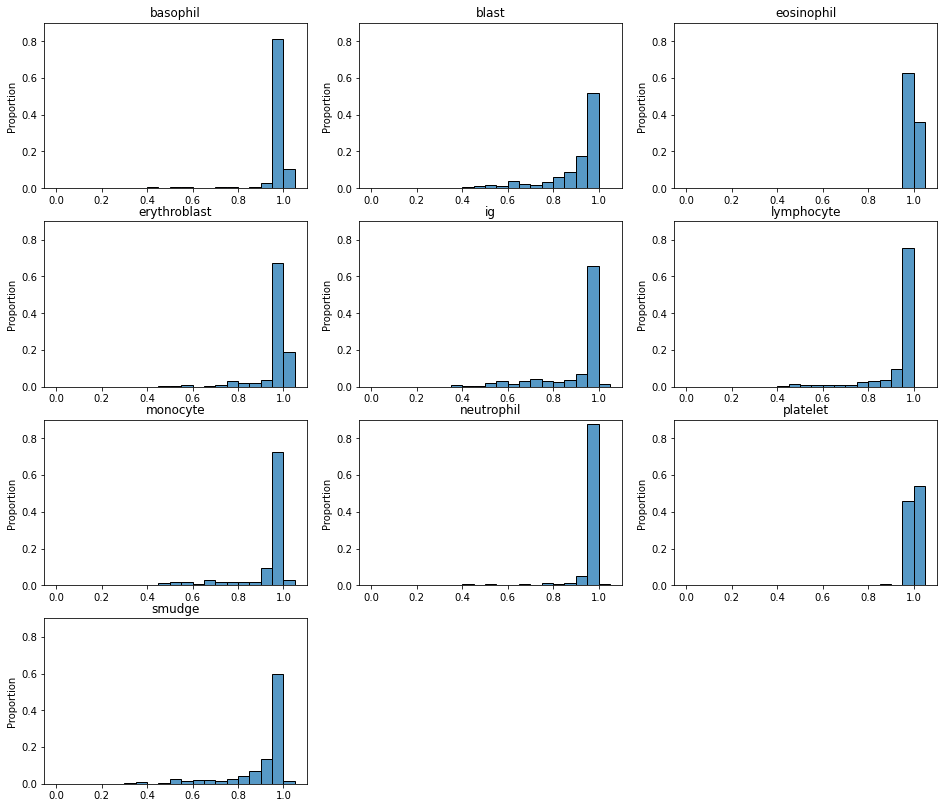

In [42]:
fig = plt.figure(figsize=(16,14))
for i in range(10):
        ax = fig.add_subplot(4, 3, i + 1)
        ax.set_ylim([0,0.9])
        plt.title(lst_classes[i])
        sns.histplot(x=predict_by_class[i],ax=ax,stat='proportion', bins = np.arange(0,1.1,0.05) )

> % similaire sans augmentation de données


### GRAD CAM

In [43]:
import gradcam_dataset

In [44]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 256, 256, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization_1[0][0]            
_______________________________________________________________________________________

block4d_expand_bn (BatchNormali (None, 16, 16, 480)  1920        block4d_expand_conv[0][0]        
__________________________________________________________________________________________________
block4d_expand_activation (Acti (None, 16, 16, 480)  0           block4d_expand_bn[0][0]          
__________________________________________________________________________________________________
block4d_dwconv (DepthwiseConv2D (None, 16, 16, 480)  4320        block4d_expand_activation[0][0]  
__________________________________________________________________________________________________
block4d_bn (BatchNormalization) (None, 16, 16, 480)  1920        block4d_dwconv[0][0]             
__________________________________________________________________________________________________
block4d_activation (Activation) (None, 16, 16, 480)  0           block4d_bn[0][0]                 
__________________________________________________________________________________________________
block4d_se

In [46]:
img_size = (256, 256)
last_conv_layer_name = "top_conv"

In [50]:
def load_and_preprocess(img_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize_with_crop_or_pad(img, 256, 256)
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img) 
    return img

##### BASOPHIL

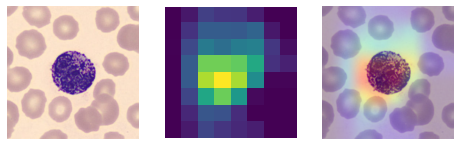

In [51]:
path = data[data['filename']=='BA_799126.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=0)

##### BLAST

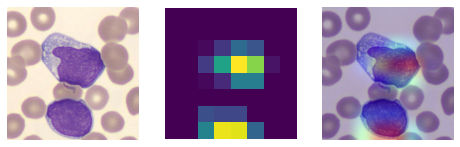

In [52]:
path = data[data['filename']=='BL_6995975.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=1)

##### EOSINOPHIL

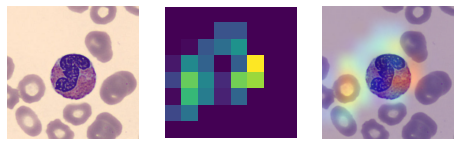

In [53]:
path = data[data['filename']=='EO_336686.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=2)

##### ERYTHROBLAST

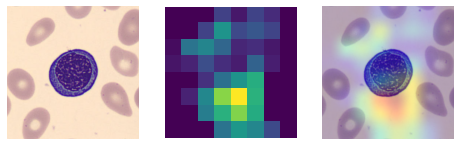

In [55]:
path = data[data['filename']=='ERB_7315.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=3)

##### IG

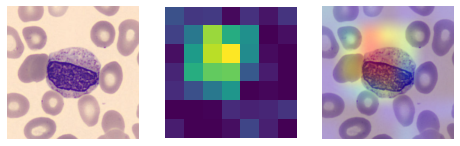

In [33]:
path = data[data['filename']=='MMY_353176.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=4)

##### LYMPHOCYTE

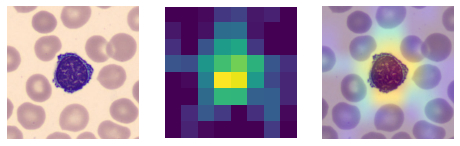

In [58]:
path = data[data['filename']=='LY_32523.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=5)

##### MONOCYTE

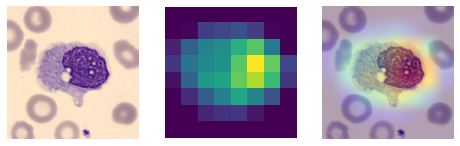

In [59]:
path = data[data['filename']=='MO_144054.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=6)

##### NEUTROPHIL

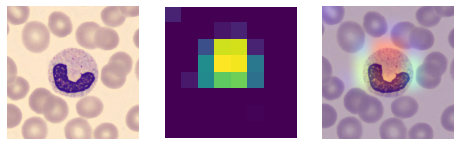

In [60]:
path = data[data['filename']=='BNE_495973.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=7)

##### PLATELET

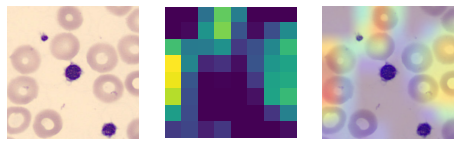

In [61]:
path = data[data['filename']=='PLATELET_57415.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=8)

##### SMUDGE

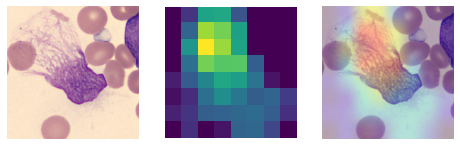

In [62]:
path = data[data['filename']=='SMU_13827002.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=9)